In [ ]:
# Install PatchTST
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-omji8yyz
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-omji8yyz
  Resolved https://github.com/huggingface/transformers.git to commit e68146fbe7052a6dc8456f48edabe705dc1f7381
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.56.0.dev0-py3-none-any.whl size=12586691 sha256=8018743db1279d413a6978a9c17d7c9305e4f709d50f65ba7e125202c13bc784
  Stored in directory: /tmp/pip-ephem-wheel-cache-a68q54e8/wheels/54/cb/3f/83103de5575c534436d6a4686686dead458238dfaf1147e98d
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.2
    Uninstalling transformers-4.55.2:
      Successfully uninstalled transformers-4.55.2


In [ ]:
columns_to_keep = [
    'datetime', 'machineID',
    'volt', 'rotate', 'pressure', 'vibration',
    'will_fail_24h', 'will_fail_48h', 'will_fail_72h'
]

df_train = df_train[columns_to_keep]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/My Drive/final_dataset.csv'
df_train = pd.read_csv(file_path)

In [ ]:
print(df_train.head())

              datetime  machineID        volt      rotate    pressure  \
0  2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1  2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2  2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3  2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4  2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  will_fail_24h  will_fail_48h  will_fail_72h  
0  45.087686              0              0              0  
1  43.413973              0              0              0  
2  34.178847              0              0              0  
3  41.122144              0              0              0  
4  25.990511              0              0              0  


In [ ]:
df_train.shape

(876100, 9)

In [ ]:
import pandas as pd
import numpy as np

df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_train = df_train.sort_values(['machineID', 'datetime']).reset_index(drop=True)

# Time-based split
cut1, cut2 = df_train['datetime'].quantile([0.65, 0.80])
train = df_train[df_train['datetime'] <= cut1].copy()
val   = df_train[(df_train['datetime'] > cut1) & (df_train['datetime'] <= cut2)].copy()
test  = df_train[df_train['datetime'] > cut2].copy()

# Imbalance report
targets = ['will_fail_24h', 'will_fail_48h', 'will_fail_72h']

def describe_split_multi(name, d, targets):
    n = len(d)
    tmin, tmax = d['datetime'].min(), d['datetime'].max()
    print(f"{name:>6}: n={n:,}  time {tmin} → {tmax}")
    for t in targets:
        pos = int(d[t].sum())
        rate = pos / n if n else 0.0
        print(f"   {t}: positives={pos:,}  rate={rate:.3%}")

describe_split_multi('train', train, targets)
describe_split_multi('  val', val, targets)
describe_split_multi(' test', test, targets)


 train: n=569,500  time 2015-01-01 06:00:00 → 2015-08-26 12:00:00
   will_fail_24h: positives=11,423  rate=2.006%
   will_fail_48h: positives=22,467  rate=3.945%
   will_fail_72h: positives=33,607  rate=5.901%
   val: n=131,400  time 2015-08-26 13:00:00 → 2015-10-20 06:00:00
   will_fail_24h: positives=2,619  rate=1.993%
   will_fail_48h: positives=5,279  rate=4.018%
   will_fail_72h: positives=7,844  rate=5.970%
  test: n=175,200  time 2015-10-20 07:00:00 → 2016-01-01 06:00:00
   will_fail_24h: positives=3,141  rate=1.793%
   will_fail_48h: positives=6,213  rate=3.546%
   will_fail_72h: positives=9,284  rate=5.299%


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Identify columns to scale (exclude identifiers and all targets)
cols_to_exclude = ['datetime', 'machineID', 'will_fail_24h', 'will_fail_48h', 'will_fail_72h']
feature_cols = [col for col in train.columns if col not in cols_to_exclude]

print(f"Scaling {len(feature_cols)} features...")

# Fit scaler only on training data
scaler = StandardScaler()
scaler.fit(train[feature_cols])

# Transform all splits using training statistics
train_scaled = train.copy()
val_scaled = val.copy()
test_scaled = test.copy()

train_scaled[feature_cols] = scaler.transform(train[feature_cols]).astype(np.float32)
val_scaled[feature_cols]   = scaler.transform(val[feature_cols]).astype(np.float32)
test_scaled[feature_cols]  = scaler.transform(test[feature_cols]).astype(np.float32)

print("Scaling completed!")
print("Train scaled shape:", train_scaled.shape)
print("Val scaled shape:", val_scaled.shape)
print("Test scaled shape:", test_scaled.shape)


Scaling 4 features...
Scaling completed!
Train scaled shape: (569500, 9)
Val scaled shape: (131400, 9)
Test scaled shape: (175200, 9)


🚀 STARTING SEQUENTIAL MULTI-TARGET PATCHTST TRAINING
Context length: 96 hours
Batch size: 8
Epochs: 3
Targets: will_fail_24h, will_fail_48h, will_fail_72h

🎯 TRAINING TARGET 1/3: will_fail_24h

TRAINING MODEL FOR: will_fail_24h
Creating datasets...
Preprocessing data for fast sequence creation...
Creating sequences using vectorized operations...
Estimated 560,000 sequences to create...


Processing machines: 100%|██████████| 100/100 [00:02<00:00, 48.50it/s]


✅ Created 560,000 sequences for will_fail_24h
Sequence shape: (560000, 96, 14)
Memory usage: 2.80 GB
will_fail_24h distribution: Class 0: 549,171, Class 1: 10,829
Preprocessing data for fast sequence creation...
Creating sequences using vectorized operations...
Estimated 121,900 sequences to create...


Processing machines: 100%|██████████| 100/100 [00:00<00:00, 220.72it/s]


✅ Created 121,900 sequences for will_fail_24h
Sequence shape: (121900, 96, 14)
Memory usage: 0.61 GB
will_fail_24h distribution: Class 0: 119,563, Class 1: 2,337
Preprocessing data for fast sequence creation...
Creating sequences using vectorized operations...
Estimated 165,700 sequences to create...


Processing machines: 100%|██████████| 100/100 [00:00<00:00, 164.02it/s]


✅ Created 165,700 sequences for will_fail_24h
Sequence shape: (165700, 96, 14)
Memory usage: 0.83 GB
will_fail_24h distribution: Class 0: 162,676, Class 1: 3,024
Number of input features: 14
will_fail_24h - Class distribution: No Failure=549,171, Failure=10,829
will_fail_24h - Positive class weight: 50.71
Model loaded on: cuda
Training batches: 70000, Validation batches: 15238, Test batches: 20713

--- Epoch 1/3 for will_fail_24h ---


Evaluating Validation: 100%|██████████| 15238/15238 [00:57<00:00, 262.97it/s]


Train Loss: 0.0206, Val Loss: 0.0225
✅ New best model saved!

--- Epoch 2/3 for will_fail_24h ---


Evaluating Validation: 100%|██████████| 15238/15238 [00:57<00:00, 263.60it/s]


Train Loss: 0.0149, Val Loss: 0.0188
✅ New best model saved!

--- Epoch 3/3 for will_fail_24h ---


Evaluating Validation: 100%|██████████| 15238/15238 [00:57<00:00, 265.57it/s]


Train Loss: 0.0128, Val Loss: 0.0164
✅ New best model saved!

EVALUATING will_fail_24h ON ALL DATASETS


Evaluating Test: 100%|██████████| 20713/20713 [01:17<00:00, 266.18it/s]



TRAINING RESULTS for will_fail_24h:
Loss: 0.0103
              precision    recall  f1-score   support

  No Failure       1.00      1.00      1.00    549171
     Failure       0.87      0.95      0.91     10829

    accuracy                           1.00    560000
   macro avg       0.94      0.97      0.95    560000
weighted avg       1.00      1.00      1.00    560000

Business Metrics:
  Failures caught: 10271/10829 (94.8%)
  Precision: 87.2%
  Missed failures: 558
  False alarms: 1510
  AUC Score: 0.999
  Average Precision: 0.946

VALIDATION RESULTS for will_fail_24h:
Loss: 0.0164
              precision    recall  f1-score   support

  No Failure       1.00      1.00      1.00    119563
     Failure       0.82      0.92      0.86      2337

    accuracy                           0.99    121900
   macro avg       0.91      0.96      0.93    121900
weighted avg       0.99      0.99      0.99    121900

Business Metrics:
  Failures caught: 2145/2337 (91.8%)
  Precision: 81.6%
  Mi

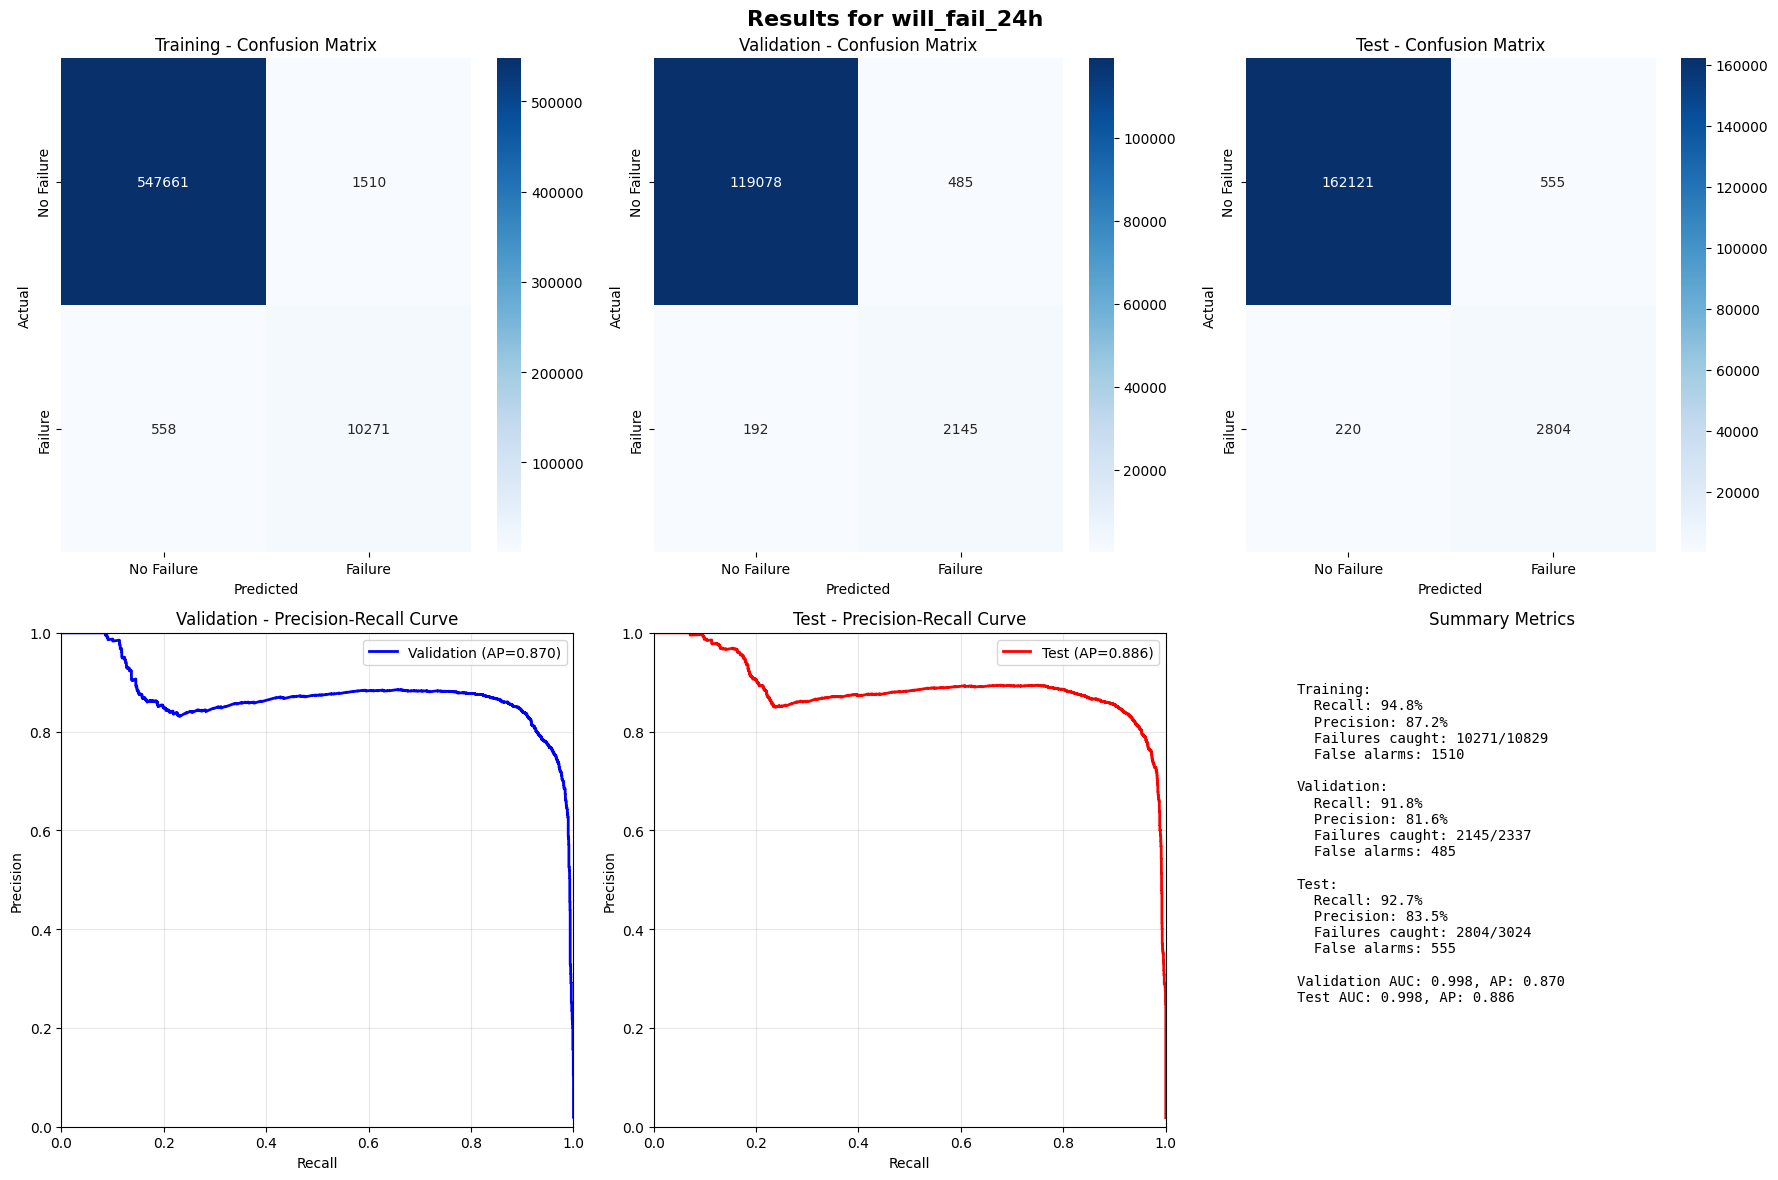

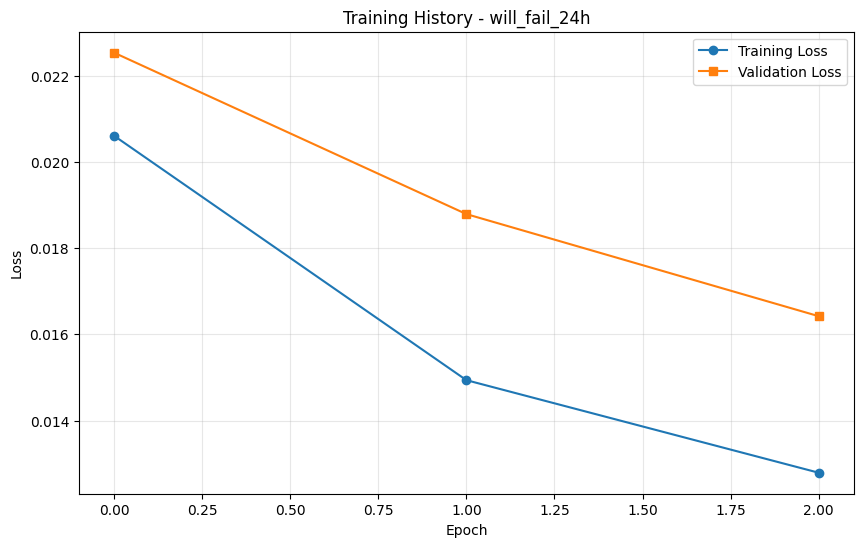


✅ will_fail_24h TRAINING AND EVALUATION COMPLETE!
Model saved as: best_patchtst_will_fail_24h_model.pth
Results saved as: will_fail_24h_results.png
Training history saved as: will_fail_24h_training_history.png
✅ COMPLETED 1/3 targets

⏭️  Moving to next target...
--------------------------------------------------------------------------------

🎯 TRAINING TARGET 2/3: will_fail_48h

TRAINING MODEL FOR: will_fail_48h
Creating datasets...
Preprocessing data for fast sequence creation...
Creating sequences using vectorized operations...
Estimated 560,000 sequences to create...


Processing machines: 100%|██████████| 100/100 [00:02<00:00, 48.62it/s]


✅ Created 560,000 sequences for will_fail_48h
Sequence shape: (560000, 96, 14)
Memory usage: 2.80 GB
will_fail_48h distribution: Class 0: 538,342, Class 1: 21,658
Preprocessing data for fast sequence creation...
Creating sequences using vectorized operations...
Estimated 121,900 sequences to create...


Processing machines: 100%|██████████| 100/100 [00:00<00:00, 222.04it/s]


✅ Created 121,900 sequences for will_fail_48h
Sequence shape: (121900, 96, 14)
Memory usage: 0.61 GB
will_fail_48h distribution: Class 0: 117,217, Class 1: 4,683
Preprocessing data for fast sequence creation...
Creating sequences using vectorized operations...
Estimated 165,700 sequences to create...


Processing machines: 100%|██████████| 100/100 [00:00<00:00, 163.95it/s]


✅ Created 165,700 sequences for will_fail_48h
Sequence shape: (165700, 96, 14)
Memory usage: 0.83 GB
will_fail_48h distribution: Class 0: 159,700, Class 1: 6,000
Number of input features: 14
will_fail_48h - Class distribution: No Failure=538,342, Failure=21,658
will_fail_48h - Positive class weight: 24.86
Model loaded on: cuda
Training batches: 70000, Validation batches: 15238, Test batches: 20713

--- Epoch 1/3 for will_fail_48h ---


Evaluating Validation: 100%|██████████| 15238/15238 [00:58<00:00, 262.18it/s]


Train Loss: 0.0889, Val Loss: 0.0935
✅ New best model saved!

--- Epoch 2/3 for will_fail_48h ---


Evaluating Validation: 100%|██████████| 15238/15238 [00:57<00:00, 266.26it/s]


Train Loss: 0.0768, Val Loss: 0.1024

--- Epoch 3/3 for will_fail_48h ---


Evaluating Validation: 100%|██████████| 15238/15238 [00:58<00:00, 258.90it/s]


Train Loss: 0.0653, Val Loss: 0.1070

EVALUATING will_fail_48h ON ALL DATASETS


Evaluating Test: 100%|██████████| 20713/20713 [01:20<00:00, 258.47it/s]



TRAINING RESULTS for will_fail_48h:
Loss: 0.0812
              precision    recall  f1-score   support

  No Failure       0.97      1.00      0.98    538342
     Failure       0.77      0.34      0.48     21658

    accuracy                           0.97    560000
   macro avg       0.87      0.67      0.73    560000
weighted avg       0.97      0.97      0.97    560000

Business Metrics:
  Failures caught: 7466/21658 (34.5%)
  Precision: 76.6%
  Missed failures: 14192
  False alarms: 2276
  AUC Score: 0.950
  Average Precision: 0.623

VALIDATION RESULTS for will_fail_48h:
Loss: 0.0935
              precision    recall  f1-score   support

  No Failure       0.97      0.99      0.98    117217
     Failure       0.64      0.29      0.40      4683

    accuracy                           0.97    121900
   macro avg       0.81      0.64      0.69    121900
weighted avg       0.96      0.97      0.96    121900

Business Metrics:
  Failures caught: 1340/4683 (28.6%)
  Precision: 64.3%
  M

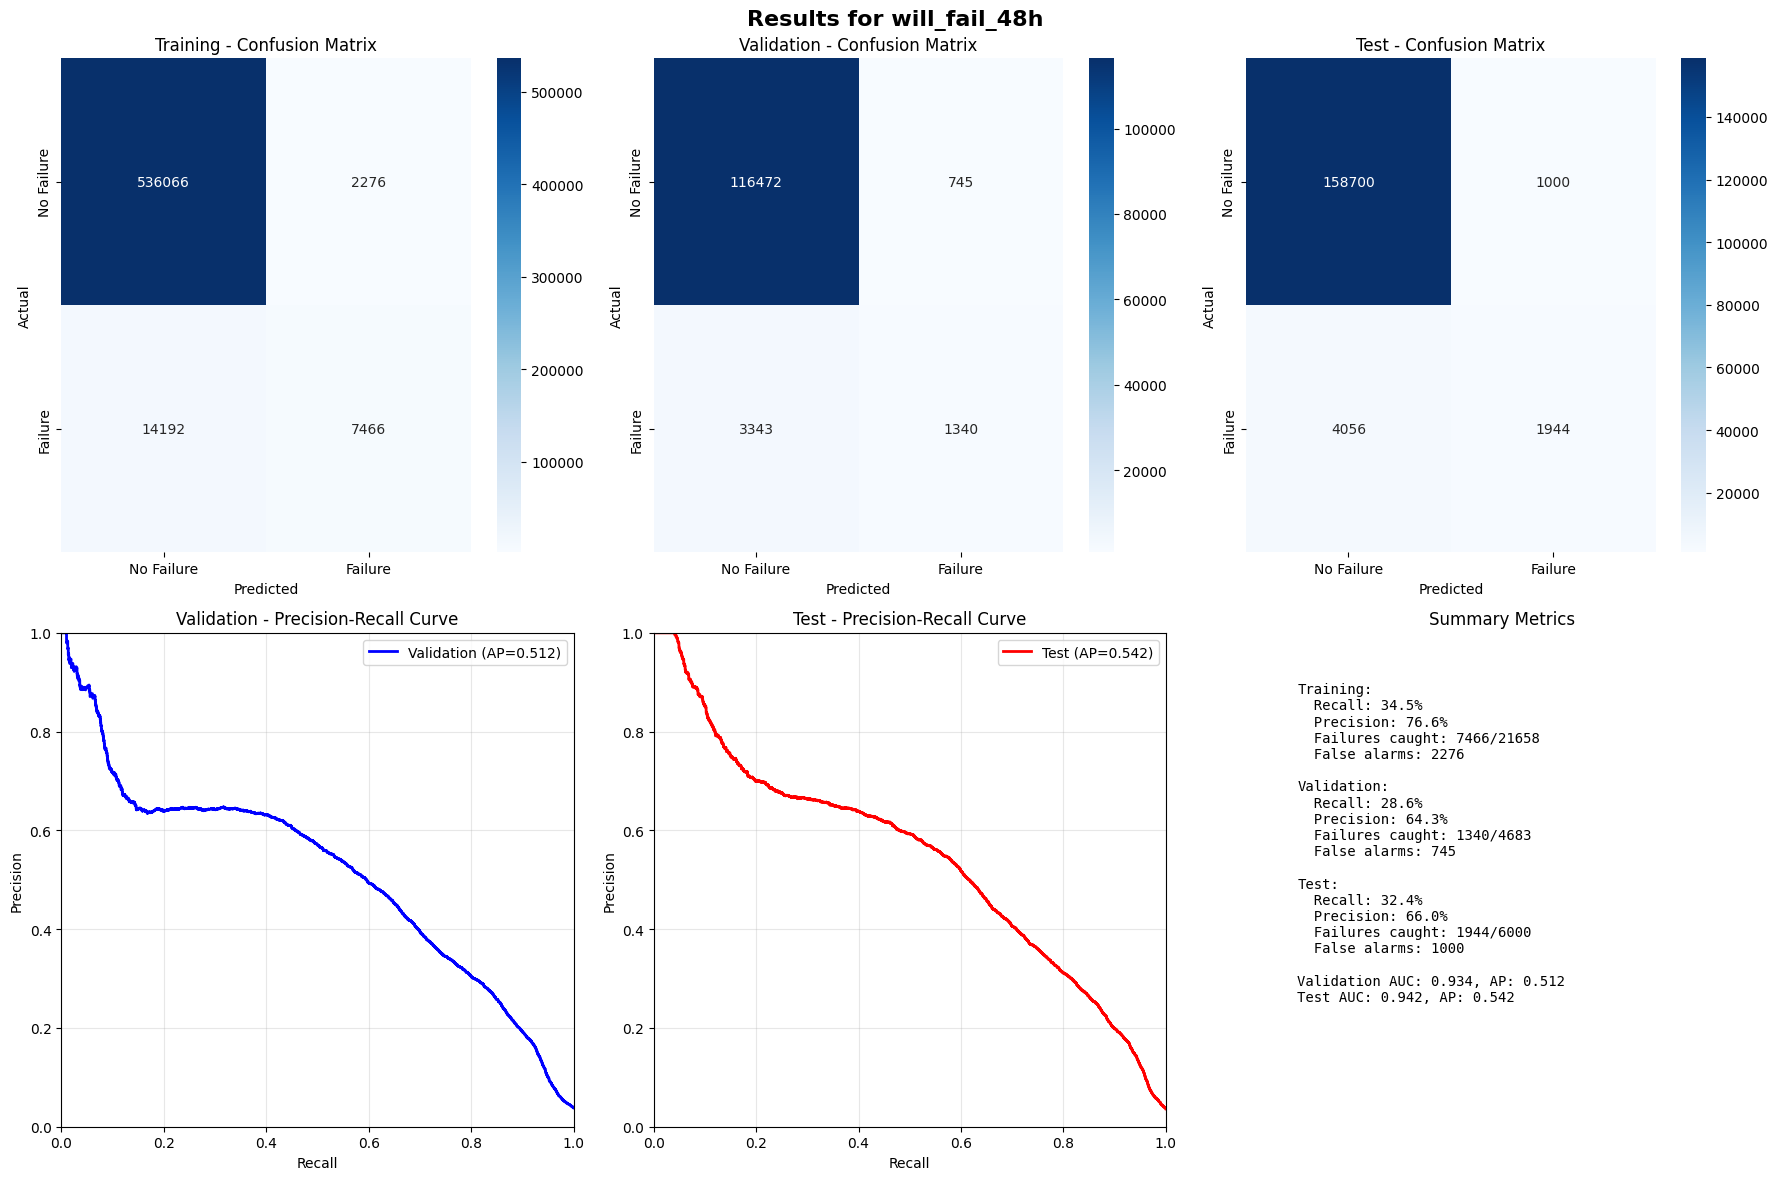

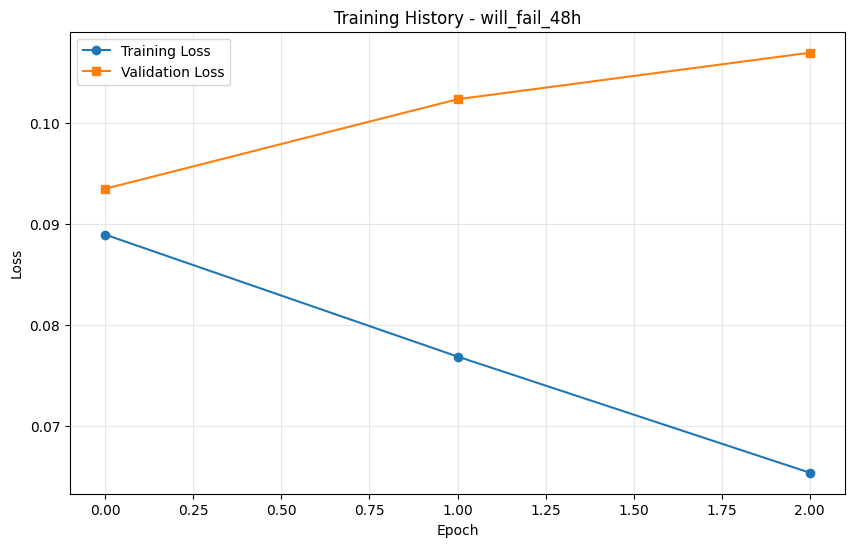


✅ will_fail_48h TRAINING AND EVALUATION COMPLETE!
Model saved as: best_patchtst_will_fail_48h_model.pth
Results saved as: will_fail_48h_results.png
Training history saved as: will_fail_48h_training_history.png
✅ COMPLETED 2/3 targets

⏭️  Moving to next target...
--------------------------------------------------------------------------------

🎯 TRAINING TARGET 3/3: will_fail_72h

TRAINING MODEL FOR: will_fail_72h
Creating datasets...
Preprocessing data for fast sequence creation...
Creating sequences using vectorized operations...
Estimated 560,000 sequences to create...


Processing machines: 100%|██████████| 100/100 [00:02<00:00, 48.41it/s]


✅ Created 560,000 sequences for will_fail_72h
Sequence shape: (560000, 96, 14)
Memory usage: 2.80 GB
will_fail_72h distribution: Class 0: 527,487, Class 1: 32,513
Preprocessing data for fast sequence creation...
Creating sequences using vectorized operations...
Estimated 121,900 sequences to create...


Processing machines: 100%|██████████| 100/100 [00:00<00:00, 222.31it/s]


✅ Created 121,900 sequences for will_fail_72h
Sequence shape: (121900, 96, 14)
Memory usage: 0.61 GB
will_fail_72h distribution: Class 0: 114,918, Class 1: 6,982
Preprocessing data for fast sequence creation...
Creating sequences using vectorized operations...
Estimated 165,700 sequences to create...


Processing machines: 100%|██████████| 100/100 [00:00<00:00, 164.44it/s]


✅ Created 165,700 sequences for will_fail_72h
Sequence shape: (165700, 96, 14)
Memory usage: 0.83 GB
will_fail_72h distribution: Class 0: 156,724, Class 1: 8,976
Number of input features: 14
will_fail_72h - Class distribution: No Failure=527,487, Failure=32,513
will_fail_72h - Positive class weight: 16.22
Model loaded on: cuda
Training batches: 70000, Validation batches: 15238, Test batches: 20713

--- Epoch 1/3 for will_fail_72h ---


Evaluating Validation: 100%|██████████| 15238/15238 [00:59<00:00, 257.67it/s]


Train Loss: 0.1660, Val Loss: 0.1710
✅ New best model saved!

--- Epoch 2/3 for will_fail_72h ---


Evaluating Validation: 100%|██████████| 15238/15238 [00:59<00:00, 257.76it/s]


Train Loss: 0.1435, Val Loss: 0.2040

--- Epoch 3/3 for will_fail_72h ---


Evaluating Validation: 100%|██████████| 15238/15238 [00:58<00:00, 260.48it/s]


Train Loss: 0.1079, Val Loss: 0.2661

EVALUATING will_fail_72h ON ALL DATASETS


Evaluating Test: 100%|██████████| 20713/20713 [01:20<00:00, 258.33it/s]



TRAINING RESULTS for will_fail_72h:
Loss: 0.1532
              precision    recall  f1-score   support

  No Failure       0.96      0.99      0.98    527487
     Failure       0.75      0.31      0.44     32513

    accuracy                           0.95    560000
   macro avg       0.86      0.65      0.71    560000
weighted avg       0.95      0.95      0.94    560000

Business Metrics:
  Failures caught: 10137/32513 (31.2%)
  Precision: 75.1%
  Missed failures: 22376
  False alarms: 3361
  AUC Score: 0.849
  Average Precision: 0.499

VALIDATION RESULTS for will_fail_72h:
Loss: 0.1710
              precision    recall  f1-score   support

  No Failure       0.96      0.99      0.97    114918
     Failure       0.61      0.26      0.36      6982

    accuracy                           0.95    121900
   macro avg       0.78      0.62      0.67    121900
weighted avg       0.94      0.95      0.94    121900

Business Metrics:
  Failures caught: 1781/6982 (25.5%)
  Precision: 61.3%
  

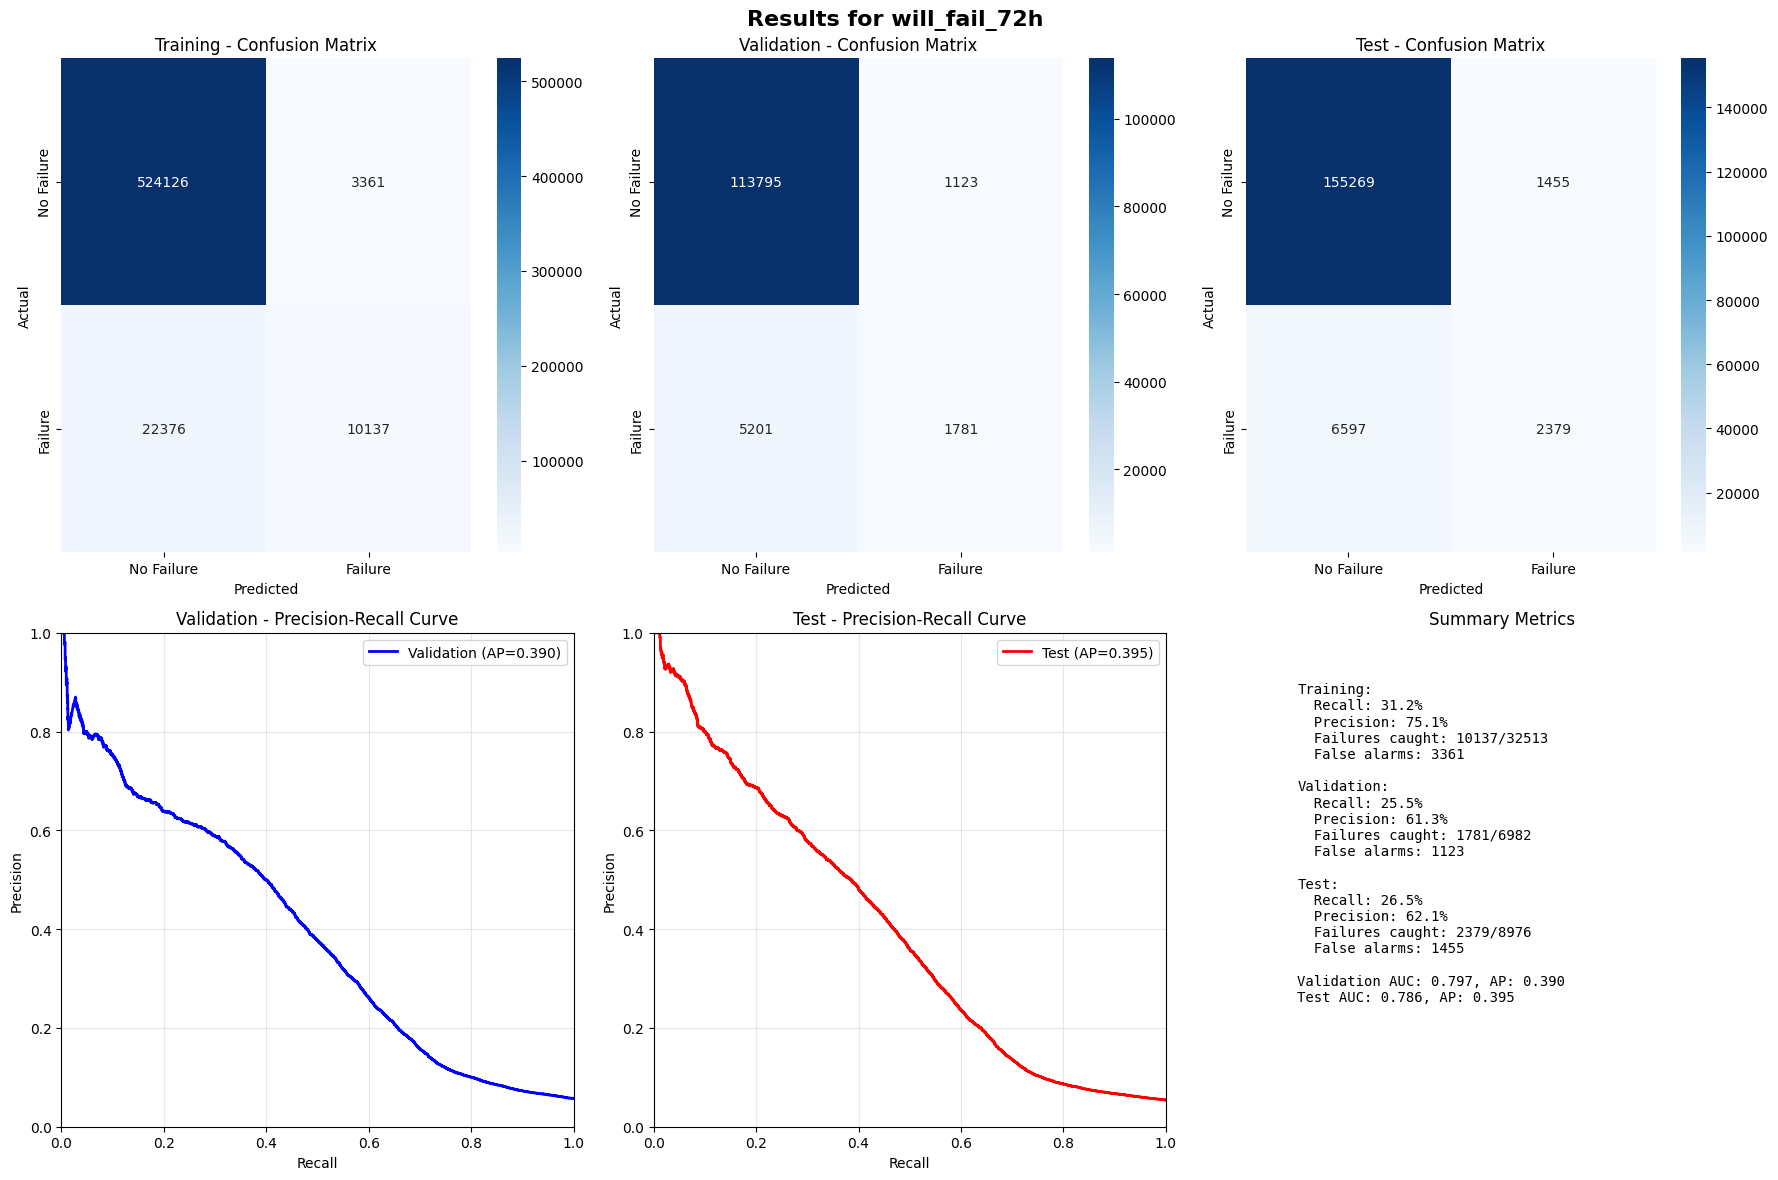

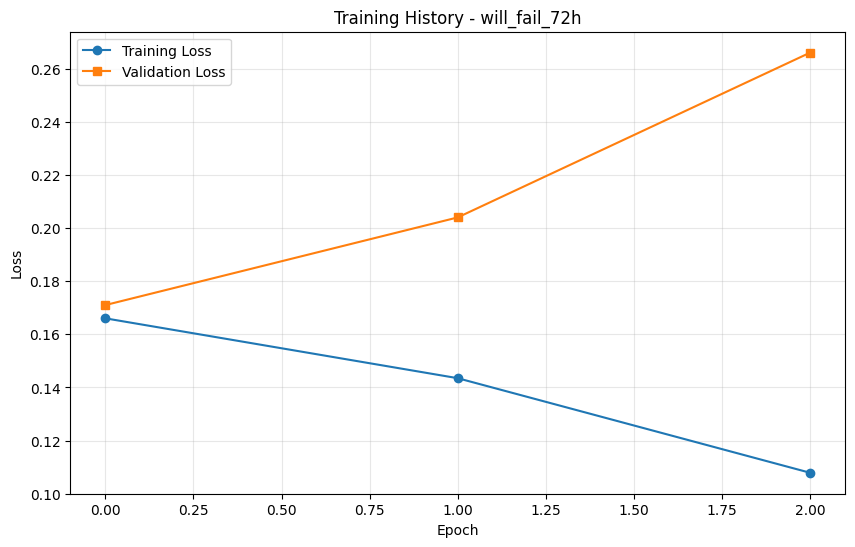


✅ will_fail_72h TRAINING AND EVALUATION COMPLETE!
Model saved as: best_patchtst_will_fail_72h_model.pth
Results saved as: will_fail_72h_results.png
Training history saved as: will_fail_72h_training_history.png
✅ COMPLETED 3/3 targets

🎉 ALL TARGETS COMPLETED!
Summary of saved files:
  - best_patchtst_will_fail_24h_model.pth
  - will_fail_24h_results.png
  - will_fail_24h_training_history.png
  - best_patchtst_will_fail_48h_model.pth
  - will_fail_48h_results.png
  - will_fail_48h_training_history.png
  - best_patchtst_will_fail_72h_model.pth
  - will_fail_72h_results.png
  - will_fail_72h_training_history.png


In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import PatchTSTConfig, PatchTSTForClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

class TimeSeriesDataset(Dataset):
    def __init__(self, df, context_length=96, target_col='will_fail_24h'):
        self.context_length = context_length
        self.target_col = target_col

        # Get feature columns (exclude metadata and all target columns)
        target_cols = ['will_fail_24h', 'will_fail_48h', 'will_fail_72h']
        self.feature_cols = [col for col in df.columns
                           if col not in ['datetime', 'machineID'] + target_cols]

        print("Preprocessing data for fast sequence creation...")

        # Sort by machine and time
        df_sorted = df.sort_values(['machineID', 'datetime']).reset_index(drop=True)

        # Pre-compute machine boundaries for vectorized operations
        machine_ids = df_sorted['machineID'].values
        machine_boundaries = np.where(np.diff(machine_ids, prepend=machine_ids[0]-1) != 0)[0]
        machine_boundaries = np.append(machine_boundaries, len(df_sorted))

        print("Creating sequences using vectorized operations...")

        # Pre-allocate arrays for better memory efficiency
        total_sequences = sum(max(0, (machine_boundaries[i+1] - machine_boundaries[i]) - context_length + 1)
                            for i in range(len(machine_boundaries)-1))

        if total_sequences == 0:
            raise ValueError("No valid sequences can be created. Check context_length vs data length.")

        print(f"Estimated {total_sequences:,} sequences to create...")

        # Pre-allocate numpy arrays
        num_features = len(self.feature_cols)
        self.sequences = np.empty((total_sequences, context_length, num_features), dtype=np.float32)
        self.targets = np.empty(total_sequences, dtype=np.int64)

        # Convert feature columns to numpy for faster access
        features_array = df_sorted[self.feature_cols].values.astype(np.float32)
        targets_array = df_sorted[target_col].values.astype(np.int64)

        # Vectorized sequence creation
        seq_idx = 0
        for i in tqdm(range(len(machine_boundaries)-1), desc="Processing machines"):
            start_idx = machine_boundaries[i]
            end_idx = machine_boundaries[i+1]
            machine_length = end_idx - start_idx

            if machine_length < context_length:
                continue

            # Number of sequences for this machine
            num_sequences = machine_length - context_length + 1

            # Vectorized sliding window using numpy array operations
            for j in range(num_sequences):
                # Extract sequence using array slicing
                self.sequences[seq_idx] = features_array[start_idx + j:start_idx + j + context_length]

                # Extract target from the last timestamp in sequence
                target_idx = start_idx + j + context_length - 1
                self.targets[seq_idx] = targets_array[target_idx]

                seq_idx += 1

        if seq_idx < total_sequences:
            self.sequences = self.sequences[:seq_idx]
            self.targets = self.targets[:seq_idx]

        print(f"✅ Created {len(self.sequences):,} sequences for {target_col}")
        print(f"Sequence shape: {self.sequences.shape}")
        print(f"Memory usage: {self.sequences.nbytes / (1024**3):.2f} GB")

        # Print target distribution
        unique, counts = np.unique(self.targets, return_counts=True)
        dist_str = ", ".join([f"Class {u}: {c:,}" for u, c in zip(unique, counts)])
        print(f"{target_col} distribution: {dist_str}")

        clear_memory()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.targets[idx])

def plot_single_target_results(train_targets, train_preds, val_targets, val_preds, val_probs,
                              test_targets, test_preds, test_probs, target_col):

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Results for {target_col}', fontsize=16, fontweight='bold')

    # Confusion Matrices
    datasets = [('Training', train_targets, train_preds),
                ('Validation', val_targets, val_preds),
                ('Test', test_targets, test_preds)]

    for i, (name, targets, preds) in enumerate(datasets):
        cm = confusion_matrix(targets, preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Failure', 'Failure'],
                   yticklabels=['No Failure', 'Failure'],
                   ax=axes[0, i])
        axes[0, i].set_title(f'{name} - Confusion Matrix')
        axes[0, i].set_xlabel('Predicted')
        axes[0, i].set_ylabel('Actual')

    # Precision-Recall Curves
    datasets_with_probs = [('Validation', val_targets, val_probs),
                          ('Test', test_targets, test_probs)]

    colors = ['blue', 'red']
    for i, (name, targets, probs) in enumerate(datasets_with_probs):
        precision, recall, _ = precision_recall_curve(targets, probs[:, 1])
        ap_score = average_precision_score(targets, probs[:, 1])
        axes[1, i].plot(recall, precision, color=colors[i], linewidth=2,
                       label=f'{name} (AP={ap_score:.3f})')
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'{name} - Precision-Recall Curve')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)
        axes[1, i].set_xlim([0, 1])
        axes[1, i].set_ylim([0, 1])

    # Summary metrics in text
    summary_text = []
    for name, targets, preds in datasets:
        tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0

        summary_text.append(f"{name}:")
        summary_text.append(f"  Recall: {recall:.1%}")
        summary_text.append(f"  Precision: {precision:.1%}")
        summary_text.append(f"  Failures caught: {tp}/{tp+fn}")
        summary_text.append(f"  False alarms: {fp}")
        summary_text.append("")

    # Add AUC scores for validation and test
    for name, targets, probs in datasets_with_probs:
        auc = roc_auc_score(targets, probs[:, 1])
        ap = average_precision_score(targets, probs[:, 1])
        summary_text.append(f"{name} AUC: {auc:.3f}, AP: {ap:.3f}")

    axes[1, 2].text(0.1, 0.9, '\n'.join(summary_text), transform=axes[1, 2].transAxes,
                   fontsize=10, verticalalignment='top', fontfamily='monospace')
    axes[1, 2].set_title('Summary Metrics')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.savefig(f'{target_col}_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def evaluate_single_target_model(model, data_loader, device, dataset_name):
    model.eval()

    all_targets = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for sequences, targets in tqdm(data_loader, desc=f"Evaluating {dataset_name}"):
            sequences, targets = sequences.to(device), targets.to(device)

            outputs = model(past_values=sequences, target_values=targets)
            total_loss += outputs.loss.item()

            predictions = outputs.prediction_logits.argmax(dim=-1)
            probabilities = torch.softmax(outputs.prediction_logits, dim=-1)

            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predictions.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    return np.array(all_targets), np.array(all_preds), np.array(all_probs), total_loss / len(data_loader)

def train_single_target_patchtst(train_df, val_df, test_df, target_col, context_length=96, batch_size=16, epochs=3):
    """Train and evaluate a single target model with immediate results"""

    print(f"\n{'='*80}")
    print(f"TRAINING MODEL FOR: {target_col}")
    print(f"{'='*80}")

    # Create datasets for single target
    print("Creating datasets...")
    train_dataset = TimeSeriesDataset(train_df, context_length=context_length, target_col=target_col)
    val_dataset = TimeSeriesDataset(val_df, context_length=context_length, target_col=target_col)
    test_dataset = TimeSeriesDataset(test_df, context_length=context_length, target_col=target_col)

    # Get number of features
    num_features = train_dataset.sequences.shape[2]
    print(f"Number of input features: {num_features}")

    # Create data loaders
    num_workers = min(4, torch.get_num_threads()) if torch.cuda.is_available() else 2

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                            num_workers=num_workers, pin_memory=torch.cuda.is_available(),
                            persistent_workers=True if num_workers > 0 else False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=torch.cuda.is_available(),
                          persistent_workers=True if num_workers > 0 else False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=torch.cuda.is_available(),
                           persistent_workers=True if num_workers > 0 else False)

    # Configure model
    config = PatchTSTConfig(
        num_input_channels=num_features,
        num_targets=2,  # Binary classification
        context_length=context_length,
        patch_length=12,
        stride=12,
        use_cls_token=True,
        padding="zeros",
        d_model=128,
        num_attention_heads=4,
        num_hidden_layers=2,
        dropout=0.1
    )

    # Initialize model
    model = PatchTSTForClassification(config)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Calculate class weights
    pos_count = (train_dataset.targets == 1).sum()
    neg_count = (train_dataset.targets == 0).sum()
    pos_weight = neg_count / pos_count if pos_count > 0 else 1.0
    print(f"{target_col} - Class distribution: No Failure={neg_count:,}, Failure={pos_count:,}")
    print(f"{target_col} - Positive class weight: {pos_weight:.2f}")

    # Setup optimizer and loss
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight]).to(device))

    print(f"Model loaded on: {device}")
    print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}, Test batches: {len(test_loader)}")

    # Training loop
    best_val_loss = float('inf')
    training_history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        print(f"\n--- Epoch {epoch+1}/{epochs} for {target_col} ---")

        # Training phase
        model.train()
        train_loss = 0.0

        for batch_idx, (sequences, targets) in enumerate(tqdm(train_loader, desc=f"Training {target_col}")):
            sequences, targets = sequences.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(past_values=sequences, target_values=targets)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if batch_idx % 50 == 0:
                clear_memory()

        # Validation phase
        _, _, _, val_loss = evaluate_single_target_model(model, val_loader, device, "Validation")

        # Track training history
        avg_train_loss = train_loss / len(train_loader)
        training_history['train_loss'].append(avg_train_loss)
        training_history['val_loss'].append(val_loss)

        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_patchtst_{target_col}_model.pth')
            print("✅ New best model saved!")

        clear_memory()

    # Load best model for evaluation
    model.load_state_dict(torch.load(f'best_patchtst_{target_col}_model.pth'))

    print(f"\n{'='*60}")
    print(f"EVALUATING {target_col} ON ALL DATASETS")
    print(f"{'='*60}")

    # Evaluate on all datasets
    train_targets, train_preds, train_probs, train_loss = evaluate_single_target_model(model, train_loader, device, "Training")
    val_targets, val_preds, val_probs, val_loss = evaluate_single_target_model(model, val_loader, device, "Validation")
    test_targets, test_preds, test_probs, test_loss = evaluate_single_target_model(model, test_loader, device, "Test")

    # Print detailed results
    datasets = [('Training', train_targets, train_preds, train_probs, train_loss),
                ('Validation', val_targets, val_preds, val_probs, val_loss),
                ('Test', test_targets, test_preds, test_probs, test_loss)]

    for dataset_name, targets, preds, probs, loss in datasets:
        print(f"\n{dataset_name.upper()} RESULTS for {target_col}:")
        print(f"Loss: {loss:.4f}")
        print(classification_report(targets, preds, target_names=['No Failure', 'Failure']))

        # Business metrics
        tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0

        print("Business Metrics:")
        print(f"  Failures caught: {tp}/{tp+fn} ({recall:.1%})")
        print(f"  Precision: {precision:.1%}")
        print(f"  Missed failures: {fn}")
        print(f"  False alarms: {fp}")

        if len(np.unique(targets)) > 1:
            auc = roc_auc_score(targets, probs[:, 1])
            ap = average_precision_score(targets, probs[:, 1])
            print(f"  AUC Score: {auc:.3f}")
            print(f"  Average Precision: {ap:.3f}")

    # Generate and show visualizations immediately
    print(f"\nGenerating visualizations for {target_col}...")
    plot_single_target_results(train_targets, train_preds, val_targets, val_preds, val_probs,
                              test_targets, test_preds, test_probs, target_col)

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(training_history['train_loss'], label='Training Loss', marker='o')
    plt.plot(training_history['val_loss'], label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training History - {target_col}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{target_col}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✅ {target_col} TRAINING AND EVALUATION COMPLETE!")
    print(f"Model saved as: best_patchtst_{target_col}_model.pth")
    print(f"Results saved as: {target_col}_results.png")
    print(f"Training history saved as: {target_col}_training_history.png")

    return model, (train_targets, train_preds, train_probs), (val_targets, val_preds, val_probs), (test_targets, test_preds, test_probs)

def train_all_targets_sequentially(train_df, val_df, test_df, context_length=96, batch_size=16, epochs=3):
    """Train all targets one by one with immediate results"""

    target_cols = ['will_fail_24h', 'will_fail_48h', 'will_fail_72h']
    all_models = {}
    all_results = {}

    print("STARTING SEQUENTIAL MULTI-TARGET PATCHTST TRAINING")
    print(f"Context length: {context_length} hours")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {epochs}")
    print(f"Targets: {', '.join(target_cols)}")
    print(f"{'='*80}")

    for i, target_col in enumerate(target_cols):
        print(f"\nTRAINING TARGET {i+1}/3: {target_col}")

        model, train_results, val_results, test_results = train_single_target_patchtst(
            train_df, val_df, test_df, target_col, context_length, batch_size, epochs
        )

        all_models[target_col] = model
        all_results[target_col] = {
            'train': train_results,
            'val': val_results,
            'test': test_results
        }

        print(f"✅ COMPLETED {i+1}/3 targets")

        # Clear memory between targets
        clear_memory()

        if i < len(target_cols) - 1:
            print(f"\n⏭Moving to next target...")
            print("-" * 80)

    print(f"\n🎉 ALL TARGETS COMPLETED!")
    print("Summary of saved files:")
    for target_col in target_cols:
        print(f"  - best_patchtst_{target_col}_model.pth")
        print(f"  - {target_col}_results.png")
        print(f"  - {target_col}_training_history.png")

    return all_models, all_results

# Usage
if __name__ == "__main__":
    # Configuration
    CONTEXT_LENGTH = 96  # 96 hours = 4 days of data
    BATCH_SIZE = 8  # Keep small for memory efficiency
    EPOCHS = 3

    # Train all targets sequentially with immediate results
    models, results = train_all_targets_sequentially(
        train_scaled,
        val_scaled,
        test_scaled,
        context_length=CONTEXT_LENGTH,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS
    )